<h1><center> Comparing nitrate response to storm events across ecoregions </center></h1>

<h3><center> Author: Lara Munro </center></h3>

Date: December 21, 2021

Analysis done as a term project for ESCI 795.02: Topic/Hydrologic Data Analysis at the University of New Hampshire, taught by Dr Anne Lightbody.

Disclaimer: Due to the size of the data files required for these analyses, discharge data is only provided for one site, Caribou Creek. Discharge data for other sites needs to be downloaded individually and saved in a 'Data' folder in the  'discharge' subfolder. Data from other sites are reported here, however the discharge data is not included in this repository. 


# 1. Introduction

Nitrogen is considered to be the main limiting nutrient for plant growth and productivity across most ecosystems (Galloway et al. 2004, LeBauer & Treseder 2008, Thomas et al. 2010). Available nitrogen, either as nitrate (NO3) or ammonium (NH4), can enter a system through fixation by soil microorganisms, atmospheric inputs, and fertilization. It is lost through denitrification and leaching to groundwater and streams. Between inputs and outputs, this nitrogen is cycled through the ecosystem multiple times via processes like plant uptake, litter decomposition, and microbial transformation (Likens 2013). Because of their chemical properties, these available forms of nitrogen are, however, easily leached from the system, largely as nitrate. High stream nitrate concentrations can lead problems downstream like eutrophication and dead zone creation (Donner et al. 2004, He & Lu 2016).

Nitrate export to streams is influenced both by the amount of nitrate present in soil (the nitrate source) and the volume of water leaving the system (nitrate transport) (Rusjan et al. 2008, Pellerin et al. 2012). On one hand, sites with higher soil nitrate content, like fertilized sites, will lose more nitrate to leaching. On the other hand, storm events, which bring more water to the system, are known to often increase the quantity of nitrate leaving the system as it is dissolved in the storm water (Duncan et al. 2017, Jones et al. 2017, Zimmer et al. 2019). However, different land uses and environmental variables like geology and temperature can affect the effect of storms on discharge as well as nitrate cycling (Poor et al. 2007, Zhi & Li 2020). 

The goal of this project is to compare the nitrate concentration - discharge (c-Q) relationship at five sites located across the United States and see how they compare to one another to answer the following question:

<h4><center> How does the nitrate-discharge relationship vary across the United States? </center></h4>

Data from the National Ecological Observation Network (NEON) will be used to compare sites across the U.S. To verify the accuracy of the nitrate measurements and identify potential sensor drifts, these data will be compared to grab samples collected every fortnight at each site. As a whole, these results may give an indication as to how different environmental variables affect nitrate export in response to storm events.

# 2. Methods

## 2.1 Site description
Five NEON sites representing a range of climate conditions and watershed sizes were selected for this analysis and are presented in table 1. These sites are representative of a wider ecoclimatic domain, defined by NEON (figure 1). These sites are classified as wadable streams and sensors are located within a 1 km portion of the reach that is free of obstruction or major tributaries (NEON 2021). Watershed maps, along with study site locations are presented in figure 2. Each stream has two sensor stations where continuous physical and chemical data are collected. Supplementary chemistry samples are collected every two-weeks in the downstream portion of the reach. Data from the continuous sensors are the focus of these analyses, however the bi-weekly samples will be used to check for sensor accuracy and potential drift.


Table 1: Site name and environmental characteristics (Source: NEON Science 2021)

|Site Name|State|ID|Mean annual temperature (C)|Mean annual precipitation (mm)|Area (km2)|NLCD Vegetation class|
|---|---|---|---|---|---|---|
|Caribou Creek|AK|CARI|-3|262|31|Woody wetland|
|Hop Brook|MA|HOPB|7.9|1368|11.9|Evergreen forest, mixed forest|
|Walker Branch|TN|WALK|14.4|1340|1.1|Deciduous forest|
|Martha Creek|WA|MART|9.6|2329|6.3|Evergreen forest|
|Blacktail Deer Creek|WY|BLDE|3.6|481|37.8|Emergent herbaceous wetlands, shrub/scrub|



Figure 1: NEON ecoclimatic domains and site location

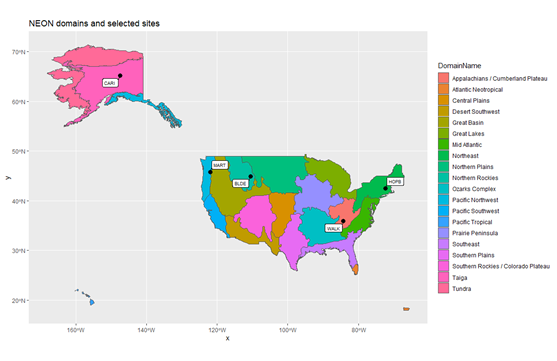

Figure 2: Watershed maps for the study sites. NEON site locations are identified in red.

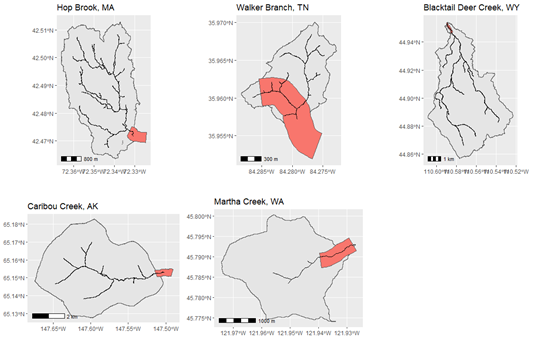


Data from 2019- 2021 are available for the selected sites and will be used for these analyses. The data products that will be used are: continuous discharge (DP4.00130.001 – 1 minute frequency), nitrate in surface water (DP1.20033.001– 15 minute frequency), and chemical properties of surface water (DP1.20093.001 – 2 week frequency). These data were downloaded in R using the NeonUtilities package, which converts and stacks the data into CSV files, along with metadata files.

## 2.2 Methods
The first step to understanding how discharge and nitrate dynamics evolve during storm events and across ecosystems was to plot discharge and nitrate concentration over time for each site. These plots also provide a visual on data availability for each measurement and site. Monthly mean nitrate concentrations were also calculated for each site and their distribution was plotted with boxplots. These plots give an indication of the range of nitrate concentrations at each site. 


The first three block of code in this notebook should only be run once, at the beginning of analysis. These blocks represent variables and functions that should not be defined more than once. The subsequent blocks of code should be run for each site, after modifying the 'nb' variable to correspond with each site.

The first steps of data analysis involve preparing the Python space: loading relevant libraries, creating static variables, and defining functions. The static variables are: file names, site names, start and end dates, data frames that will hold results from each site, a data frame with storm dates, and unzip the data files.  

In [1]:
# Import libraries for analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as datetime
from scipy import stats
import zipfile

In [2]:
# Create variables & data frames that will not need to be changed during the analysis

# List of filenames
filenames = ['BLDE.csv', 'CARI.csv', 'HOPB.csv', 'MART.csv', 'WALK.csv']
# List of site names
sites = ['BLDE', 'CARI', 'HOPB', 'MART', 'WALK']
# List of potential NA values
potentialNA = [9999, -9999, -8888, 'T', '<0.01', 'NA', 'NaN', 'nan', 'na', ' NA']
# Start and end dates
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2021, 10, 31)

# Create a dataframe to add in changes in number of NAs
NAcount = pd.DataFrame(columns = ['site', 'Q', 'Qinterp', 'no3', 'no3interp'])
NAcount['site'] = sites
NAcount = NAcount.set_index('site')

# Create a data frame to hold monthlye mean NO3 concentrations, b, and a values for each site
dfno3mo = pd.DataFrame(columns = ['month', 'yrnb', 'monb', 'BLDE', 'CARI', 'HOPB', 'MART', 'WALK'])
dfb = pd.DataFrame(columns = ['month', 'yrnb', 'monb', 'BLDE', 'CARI', 'HOPB', 'MART', 'WALK'])
dfa = pd.DataFrame(columns = ['month', 'yrnb', 'monb', 'BLDE', 'CARI', 'HOPB', 'MART', 'WALK'])
dfno3mo['monb'] = range(1, 35)
for i in range(1, 13):
    dfno3mo.loc[dfno3mo['monb'].eq(i), "yrnb"] = 0
for i in range(13, 25):
    dfno3mo.loc[dfno3mo['monb'].eq(i), "yrnb"] = 1
for i in range(25, 35):
    dfno3mo.loc[dfno3mo['monb'].eq(i), "yrnb"] = 2
dfno3mo['month'] = dfno3mo['monb'] - dfno3mo['yrnb']*12
dfno3mo = dfno3mo.set_index(['monb'])
dfno3mo['year'] = dfno3mo['yrnb'] + 2019
dfno3mo['date'] = pd.to_datetime(dfno3mo[['year', 'month']].assign(DAY=1))

dfb['monb'] = range(1, 35)
for i in range(1, 13):
    dfb.loc[dfb['monb'].eq(i), "yrnb"] = 0
for i in range(13, 25):
    dfb.loc[dfb['monb'].eq(i), "yrnb"] = 1
for i in range(25, 35):
    dfb.loc[dfb['monb'].eq(i), "yrnb"] = 2
dfb['month'] = dfb['monb'] - dfb['yrnb']*12
dfb = dfb.set_index(['monb'])
dfb['year'] = dfb['yrnb'] + 2019
dfb['date'] = pd.to_datetime(dfb[['year', 'month']].assign(DAY=1))

dfa['monb'] = range(1, 35)
for i in range(1, 13):
    dfa.loc[dfa['monb'].eq(i), "yrnb"] = 0
for i in range(13, 25):
    dfa.loc[dfa['monb'].eq(i), "yrnb"] = 1
for i in range(25, 35):
    dfa.loc[dfa['monb'].eq(i), "yrnb"] = 2
dfa['month'] = dfa['monb'] - dfa['yrnb']*12
dfa = dfa.set_index(['monb'])
dfa['year'] = dfa['yrnb'] + 2019
dfa['date'] = pd.to_datetime(dfa[['year', 'month']].assign(DAY=1))

# Define a dfstorm data frame with 3 storm dates for each site
dfstorm = pd.DataFrame(np.array([[datetime.datetime(2019, 8, 10), datetime.datetime(2019, 8, 13)],
                                 [datetime.datetime(2020, 4, 26), datetime.datetime(2020, 4, 28)],
                                 [datetime.datetime(2021, 7, 28), datetime.datetime(2021, 7, 31)],
                                 [datetime.datetime(2019, 8, 1), datetime.datetime(2019, 8, 7)],
                                 [datetime.datetime(2019, 5, 28), datetime.datetime(2019, 6, 1)],
                                 [datetime.datetime(2019, 10, 4), datetime.datetime(2019, 10, 10)],
                                 [datetime.datetime(2020, 8, 27), datetime.datetime(2020, 8, 29)],
                                 [datetime.datetime(2020, 12, 24), datetime.datetime(2020, 12, 28)],
                                 [datetime.datetime(2021, 9, 1), datetime.datetime(2021, 9, 5)],
                                 [datetime.datetime(2019, 4, 6), datetime.datetime(2019, 4, 11)],
                                 [datetime.datetime(2019, 11, 19), datetime.datetime(2019, 11, 21)],
                                 [datetime.datetime(2020, 10, 13), datetime.datetime(2020, 10, 15)],
                                 [datetime.datetime(2019, 6, 21), datetime.datetime(2019, 6, 23)],
                                 [datetime.datetime(2020, 11, 11), datetime.datetime(2020, 11, 15)],
                                 [datetime.datetime(2021, 3, 28), datetime.datetime(2021, 3, 31)]]),
                       columns=('start', 'end'))

# Unzip the data file to the directory
with zipfile.ZipFile('./DataZipped.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
# Define the functions needed for the analyses
# Define functions to read the different data and remove flagged values
def readdisfunc(x):
    '''Read NEON continuous discharge data. Discharge units: l/s'''
    y = ('./Data/discharge/'+x)
    df = pd.read_csv(y, delimiter=',', header=0,
                     parse_dates=['endDate'], na_values=potentialNA)
    df = df.rename(columns={'endDate': "date",
                            "maxpostDischarge": "Q"
                            })
    df = df.set_index('date')
    df = df.tz_localize(None)
    df = df[start_date:end_date]
    df.loc[df['dischargeFinalQF'].eq(1), "Q"] = np.nan
    df = df[['Q']]
    df = df.where((df>0) ,np.nan)
    return df

def readno3func(x):
    '''Read NEON sensor NO3 data. Units: no3mol = micromolar/l
    no3 = g/l'''
    y = ('./Data/sensorNO3/'+x)
    df = pd.read_csv(y, delimiter=',', header=0,
                     parse_dates=['endDateTime'], 
                     na_values=potentialNA, 
                     )
    df = df.rename(columns={'endDateTime': "date",
                            "surfWaterNitrateMean": "no3mol"
                            })
    df = df.set_index('date')
    df = df.tz_localize(None)
    df = df[~df.index.duplicated(keep='first')]
    df = df[start_date:end_date]
    df.loc[df['finalQF'].eq(1), "no3mol"] = np.nan
    df['no3'] = df['no3mol']*62.0049/1000 
    df = df[['no3']]
    df = df.where((df>0) ,np.nan)
    return df

def readgrabfunc(x):
    '''Read NEON grab sample data. '''
    y = ('./Data/chemGrab/'+x)
    df = pd.read_csv(y, delimiter=',', header=0,
                     parse_dates=['collectDate'], na_values=potentialNA)
    df = df.rename(columns={'collectDate': "date",
                            ' NH4 - N': 'NH4-N', ' NO2 - N': 'NO2-N', 
                            ' NO3+NO2 - N':'NO3+NO2-N', ' TDN': 'TDN'
                            })
    df['date'] = df['date'].dt.round('15min') # Round time to the nearest 15 minute mark
    df = df.set_index('date')
    df = df[start_date:end_date]
    df = df[['NO3+NO2-N', 'TDN']]
    df = df.where((df>0) ,np.nan)
    # Replace NO3-NO2 values that are outside of a normal range of values
    grabmax = df['NO3+NO2-N'].mean() + 3*df['NO3+NO2-N'].std()
    grabmin = df['NO3+NO2-N'].mean() - 3*df['NO3+NO2-N'].std()
    df['NO3+NO2-N'] = df['NO3+NO2-N'].where(((df['NO3+NO2-N']>grabmin) & (df['NO3+NO2-N']<grabmax)) , np.nan)
    return df

def timeseriesplot(df): 
    '''Create a time series plot for discharge & NO3 conentration for each site'''
    fig, ax = plt.subplots()
    line1 = ax.plot(df['Q'], color = 'b', 
                     linestyle = '-', label = 'Discharge')    
    ax.set_ylabel('Discharge (l/s)', color = 'b')   
    ax.set_ylim(bottom = 0)
    fig.autofmt_xdate()                
    
    # Create second axis for discharge data on top of precipitation data
    ax2 = ax.twinx()
    line2 = ax2.plot(df['no3'], color = 'k', 
                     linestyle = '-', label = 'NO3')
    ax2.set_ylim(bottom = 0)
    ax2.set_ylabel('NO3 concentration (mg/l)', color = 'k')  # create teal y-axis label
    ax.set_title(site)
    # Add a legend with data from both axes
    #ax2.invert_yaxis()
    lines = line1 + line2
    labs = [l.get_label() for l in lines]
    ax.legend(lines, labs, loc='upper left')
    return plt.show()

# Calculate a linear regression between the grab sample and sensor NO3 values
def compno3vals(df):
    ''' Calculate a linear regression and Pearson correlation coefficient between grab sample 
    and sensor NO3 concentrations. Plot those data and regression.'''
    compsub = df[['no3', 'TDN', 'NO3+NO2-N']]
    compsub = compsub[np.logical_not(np.isnan(compsub))]
    idx = np.isfinite(compsub['no3']) & np.isfinite(compsub['NO3+NO2-N'])
    maxNO3 = max(compsub['NO3+NO2-N'][idx]) + 0.1*max(compsub['NO3+NO2-N'][idx])
    
    polyline = np.polyfit(compsub['NO3+NO2-N'][idx], compsub['no3'][idx], 1)
    linem = round(polyline[0], 5)
    lineb = round(polyline[1], 5)
    polyx = np.array([0, maxNO3])
    polyy = polyline[0]*polyx + polyline[1]
    
    # Calculate a Pearson correlation between the grab sample and sensor NO3
    coeff = stats.pearsonr(compsub['NO3+NO2-N'][idx], compsub['no3'][idx])
    coeffR2 = str(round(coeff[0], 2))
    coeffpval = str(round(coeff[1], 5))
    coeffitem = ('R2 = ' + coeffR2 + '\np = '+ coeffpval)
    print('The Pearson correlation coefficient between sensor and grab sample',
          'NO3 is', coeff[0], 'p =', coeff[1], 'y =', linem, "x +", lineb)
    # Plot sensor NO3 vs grab sample NO3+NO2-N
    fig, ax = plt.subplots()
    ax.scatter(x = df['NO3+NO2-N'], y = df['no3'])
    ax.plot(polyx, polyy, color = 'r')
    ax.set_xlabel('Grab sample NO3+NO2-N concentration (mg/l)')
    ax.set_ylabel('Sensor NO3 concentration (mg/l)')
    ax.set_ylim(bottom = 0)
    ax.annotate(coeffitem, xy = [(0.75*maxNO3), (0.6*polyy[1])])
    ax.set_title(site)

    return coeff, linem, lineb, plt.show()

# Calculate the b and a values of each site
def loganalysis(df):
    '''Analyse the daily NO3 vs discharge values per Wymore et al 2021 & Zimmer et al. 2019'''
    for i in (range(1, 35)):
        fart = df.loc[df['monb'] == i]
        fart = fart.resample('D').mean()
        idx = np.isfinite(fart['no3']) & np.isfinite(fart['Q'])
        try:
            logb, loga = np.polyfit(np.log10(fart['Q'][idx]), np.log10(fart['no3'][idx]), 1)
            dfa.at[i,site] = logb
            dfb.at[i,site] = loga
            dfno3mo.at[i, site] = fart['no3'].mean()
        except:
            pass
    return dfa, dfb, dfno3mo

# Plot a storm concentration vs discharge
'''Plot NO3 concentration vs discharge for simgle storm events'''
def stormcQ(df):
    fig, ax = plt.subplots()
    ax.plot(df['Q'], df['no3'], marker = '.')
    ax.set_xlabel('Discharge (l/s)')
    ax.set_ylabel('Sensor NO3 concentration (mg/l)')
    ax.set_xlim(left = 0)
    ax.set_title(site)
    return plt.show()


The following cells should be run for each site. To change the analyzed site, only the 'nb' variable needs to be changed. This variable refers to a site within the 'sites' list created above and its corresponding data files. The first cell will load the dataframes and merge them based on their collection date. The second cell will gap fill data for up to 1 hour of consecutive missing data using a linear interpolation of surrounding values. A count of non-NA data will be provided for each site for continuous discharge and nitrate measurements in the 'NAcount' data frame.

In [21]:
# Load data and merge dataframes

# Select a site
nb = 1
site = sites[nb]
sitename = filenames[nb]

# Load discharge data
disdat = readdisfunc(sitename)
# Load NO3 data
no3dat = readno3func(sitename)
# Load grab sample data
grabdat = readgrabfunc(sitename)

# Merge the grab sample and NO3 sensor dataframes 
comp = pd.merge(no3dat, grabdat, how = 'right', left_index = True, 
                  right_index = True)
# Replace sensor values that are outside of a normal range of values
sensmax = comp['no3'].mean() + 3*comp['no3'].std()
sensmin = comp['no3'].mean() - 3*comp['no3'].std()
comp['no3'] = comp['no3'].where(((comp['no3']>sensmin) & (comp['no3']<sensmax)) , np.nan)

# Merge continuous discharge and sensor NO3 data based on their sampling time
dfdat = pd.merge(no3dat, disdat, how = 'left', left_index = True, 
                  right_index = True)
dfdat = dfdat.resample(rule = '15min').mean()

# Create a column with month, year and month number
dfdat['monb'] = dfdat.index.month
dfdat['yrnb'] = dfdat.index.year - start_date.year
dfdat['monb'] = dfdat['monb'] + dfdat['yrnb']*12

# Create a data subset of dfstorm for the site being analysed
val1 = nb*3
val2 = nb*3 + 3
storms = dfstorm[val1:val2]

In [22]:
# Interpolate missing values (up to 1h) and count the number missing values
# Create a dataframe to add in changes in number of NAs
NAcount.at[site,'Q'] = np.count_nonzero(~np.isnan(dfdat['Q']))
NAcount.at[site,'no3'] = np.count_nonzero(~np.isnan(dfdat['no3']))
# Interpolate values for gaps smaller than 1 hour
dfdat = dfdat.interpolate(method = 'linear', limit = 4)
NAcount.at[site,'no3interp'] = np.count_nonzero(~np.isnan(dfdat['no3']))
NAcount.at[site,'Qinterp'] = np.count_nonzero(~np.isnan(dfdat['Q']))

NAcount

,Q,Qinterp,no3,no3interp
site,,,,
BLDE,NaN,NaN,NaN,NaN
CARI,15719,15784,26719,27016
HOPB,NaN,NaN,NaN,NaN
MART,61620,62055,54757,55787
WALK,NaN,NaN,NaN,NaN


The following two cells create figures for the data: 1) a time series of discharge and nitrate, using a function defined above, and 2) a boxplot of the distribution of mean monthly NO3 concentrations for each site.

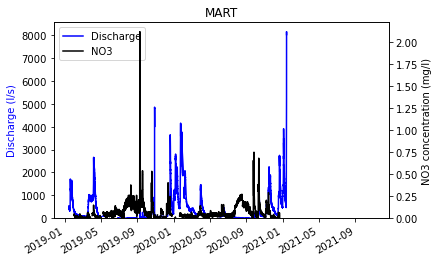

In [23]:
# Plot continuous discharge & NO3 vs time
timeseriesplot(dfdat)

1.7284270350948379

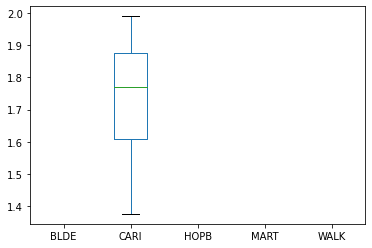

In [24]:
# Create a boxplot for each site's mean NO3 concentrations
# All of the sites need to be processed for this plot to make sense
dfno3mosub = dfno3mo[['BLDE', 'CARI', 'HOPB', 'MART', 'WALK']]
dfno3mosub.plot(kind='box')
dfno3mosub['CARI'].mean()

### 2.2.1 Consistency of nitrate measurements

Nitrate concentrations are measured at two time frequencies: every 15 minutes using NO3 sensors and every two weeks from samples collected at two locations in each stream. To determine whether these measurements are consistent, a linear regression was calculated and assessed using a Pearson correlation coefficient for samples collected and recorded within a same 15 minute interval.  


The Pearson correlation coefficient between sensor and grab sample NO3 is 0.6754668204964114 p = 0.004083763137452413 y = 1.93218 x + 0.01622


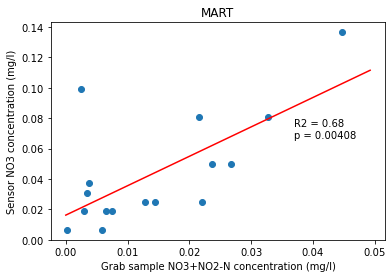

((0.6754668204964114, 0.004083763137452413), 1.93218, 0.01622, None)

In [25]:
# Compare grab sample NO3 values to sensor NO3 values
compno3vals(comp)

### 2.2.1 Consistency of nitrate measurements
Nitrate concentrations are measured at two time frequencies: every 15 minutes using nitrate sensors and every two weeks from samples collected at two locations in each stream. To determine whether these measurements are consistent, a linear regression was calculated and assessed using a Pearson correlation coefficient for samples collected and recorded within a same 15 minute interval. A first pass at these data points revealed outlier data that were outside of a plausible range of values, either negative concentrations or concentrations that were orders of magnitude larger than other values. As a result, outlier data were removed prior to analysis. Outliers were defined as values smaller than zero or greater or smaller than three times the standard deviation plus or minus the mean, respectively. 

In [26]:
# Compare discharge to NO3 measurements
# Calculate a Pearson correlation between discharge and sensor NO3 concentrations
idx = np.isfinite(dfdat['no3']) & np.isfinite(dfdat['Q'])
coeff = stats.pearsonr(dfdat['Q'][idx], dfdat['no3'][idx])
coeffR2 = str(round(coeff[0], 2))
coeffpval = str(round(coeff[1], 4))
coeffitem = ('R2 = ' + coeffR2 + '\np = '+ coeffpval)
print('The Pearson correlation coefficient between discharge and ',
      'NO3 concentration is', coeff[0], 'p =', coeff[1])

# Optional: calculate a linear regression between NO3 and discharge
polyline = np.polyfit(dfdat['Q'][idx], dfdat['no3'][idx], 1)
linem = round(polyline[0], 2)
lineb = round(polyline[1], 2)
polyx = np.array([0, 6000])
polyy = polyline[0]*polyx + polyline[1]


The Pearson correlation coefficient between discharge and  NO3 concentration is -0.07811656191632954 p = 2.0278155076940683e-67


Text(0.5, 1.0, 'MART')

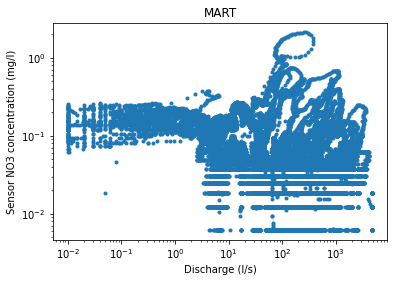

In [27]:
# Plot discharge vs sensor NO3 measurements in a log-log space
# Optional: plot the total regression if calculated above.
fig, (ax1) = plt.subplots()
ax1.scatter(x = dfdat['Q'], y = dfdat['no3'], marker = '.')
#ax1.plot(polyx, polyy, color = 'r')
ax1.set_xlabel('Discharge (l/s)')
ax1.set_ylabel('Sensor NO3 concentration (mg/l)')
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.set_xlim(left = 0)
#ax1.set_ylim(bottom = 0)
ax1.set_title(site)


### 2.2.2 Discharge and nitrate relationship
A concentration-discharge relationship was estimated for each site using nitrate sensor data and continuous discharge measurements. A Pearson correlation test was done to assess the strength of this relationship. Nitrate and discharge scatter plots are also created to visualize these relationships in a log-log space.

To better understand how the nitrate discharge relationship varies across sites, data a monthly average slope between nitrate and discharge was calculated and compared between sites. Daily mean nitrate concentrations and discharges values were calculated. Data were subdivided by month and a log-log regression was calculated between the two variables. The slope (b) of this regression was used to determine whether the site was concentrating (b > 0) or diluting (b < 0) NO3 as discharge increased (Musolff et al. 2015, Zimmer et al. 2019, Wymore et al. 2021). The range of these slope values was then plotted in a boxplot and used to understand how the different sites respond to storm events. The evolution of these slope values in time was also plotted for all sites to visualize how these dynamics vary between ecoregions.  


<ipython-input-34-e39870c8c839>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbsub['MART'] = dfbsub['MART'].where((dfbsub['MART']>(-6)) , np.nan)
<ipython-input-34-e39870c8c839>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbsub['MART'] = dfbsub['MART'].where((dfbsub['MART']>(-6)) , np.nan)
<ipython-input-34-e39870c8c839>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

1.778720979604819

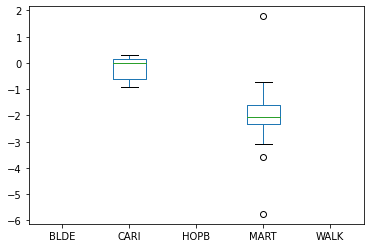

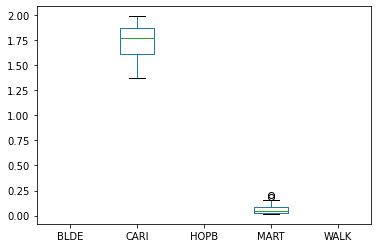

In [34]:
# Do the log(c)-log(Q) analysis for each month
loganalysis(dfdat)

# Create a boxplot of the slopes (b) & remove 2 extreme values
# All of the sites need to be processed for this plot to make sense
dfbsub = dfb[['BLDE', 'CARI', 'HOPB', 'MART', 'WALK']]
dfbsub['MART'] = dfbsub['MART'].where((dfbsub['MART']>(-6)) , np.nan)

dfbsub['MART'] = dfbsub['MART'].where((dfbsub['MART']>(-6)) , np.nan)
dfbsub['BLDE'] = dfbsub['BLDE'].where((dfbsub['BLDE']>(-6)) , np.nan)
dfbsub.plot(kind='box')

# Create a boxplot for each site's mean NO3 concentrations
# All of the sites need to be processed for this plot to make sense
dfno3mosub = dfno3mo[['BLDE', 'CARI', 'HOPB', 'MART', 'WALK']]
dfno3mosub.plot(kind='box')
dfb['MART'].max()

Text(0.5, 1.0, 'Concentration-discharge slope at five sites across the US')

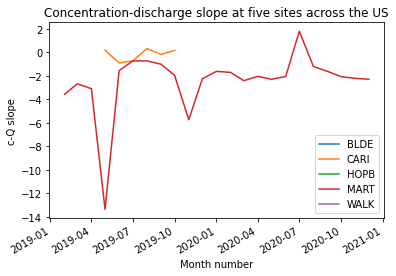

In [30]:
# Plot monthly mean NO3 concentration slope over time
fig, (ax1) = plt.subplots()
ax1.plot(dfb['date'], dfb['BLDE'], label = 'BLDE')
ax1.plot(dfb['date'], dfb['CARI'], label = 'CARI')
ax1.plot(dfb['date'], dfb['HOPB'],  label = 'HOPB')
ax1.plot(dfb['date'], dfb['MART'], label = 'MART')
ax1.plot(dfb['date'], dfb['WALK'], label = 'WALK')
ax1.legend()
fig.autofmt_xdate()
ax1.set_ylabel('c-Q slope')
ax1.set_xlabel('Month number')
ax1.set_title('Concentration-discharge slope at five sites across the US')


# 3. Results and Discussion

## 3.1 Consistency of nitrate measurements
For four out of five sites, grab samples and nitrate sensor measurements were correlated, only samples from Hop Brook were not correlated with sensor values. These four sites had a positive correlation between nitrate measurements, as expected, and the Pearson correlation coefficient was significant at p < 0.01. Three sites had strong R2 values (0.86-0.95), the other site, Martha Creek, had a less strong R2 value (0.68), highlighting the slightly more random distribution of data. The lack of correlation at Hop Brook could be because the grab sample data at this site is very sparse and thus may not fully represent the nitrate dynamics at the site. It should be noted that a perfect 1:1 line between the values was not expected: sensor data reported nitrate concentrations, whereas grab samples reported the concentration nitrogen in nitrate and nitrite. As such, the grab sample values are smaller because they represent a smaller particle, but they also represent a larger subset of nitrogen in the system because they include nitrite. This difference should not, however, cause a large difference between the values because nitrite concentrations in water are generally considered to be negligible (Paul & Clarke 1989).

The inconsistency of grab sample and sensor data at Hop Brook and Martha Creek may indicate drifts in sensor data that could be due to equipment malfunctions or changes in field conditions. In this case, a correction would need to be applied to sensor values to account for these drifts. However, the inconsistencies also raise questions about the reliability of both data sources. These questions are amplified by the need to remove certain data points that were unrealistic (either negative or very large). A recent study comparing NEON Airborne Observation Platforms (AOP) remote sensing data and vegetation data collected in the field also found mismatches between the two data sources (Pau et al. 2021). These results highlight the difficulty of developing and maintaining a large-scale ecological data repositories and the need for external analyses like the ones performed here to determine where/if an error lies.  


Figure 3: Sensor measured nitrate (NO3) concentrations and grab sample nitrogen in nitrite or nitrate (NO2 + NO3-N) concentrations. Pearson R2 values and p-value are given for each site.
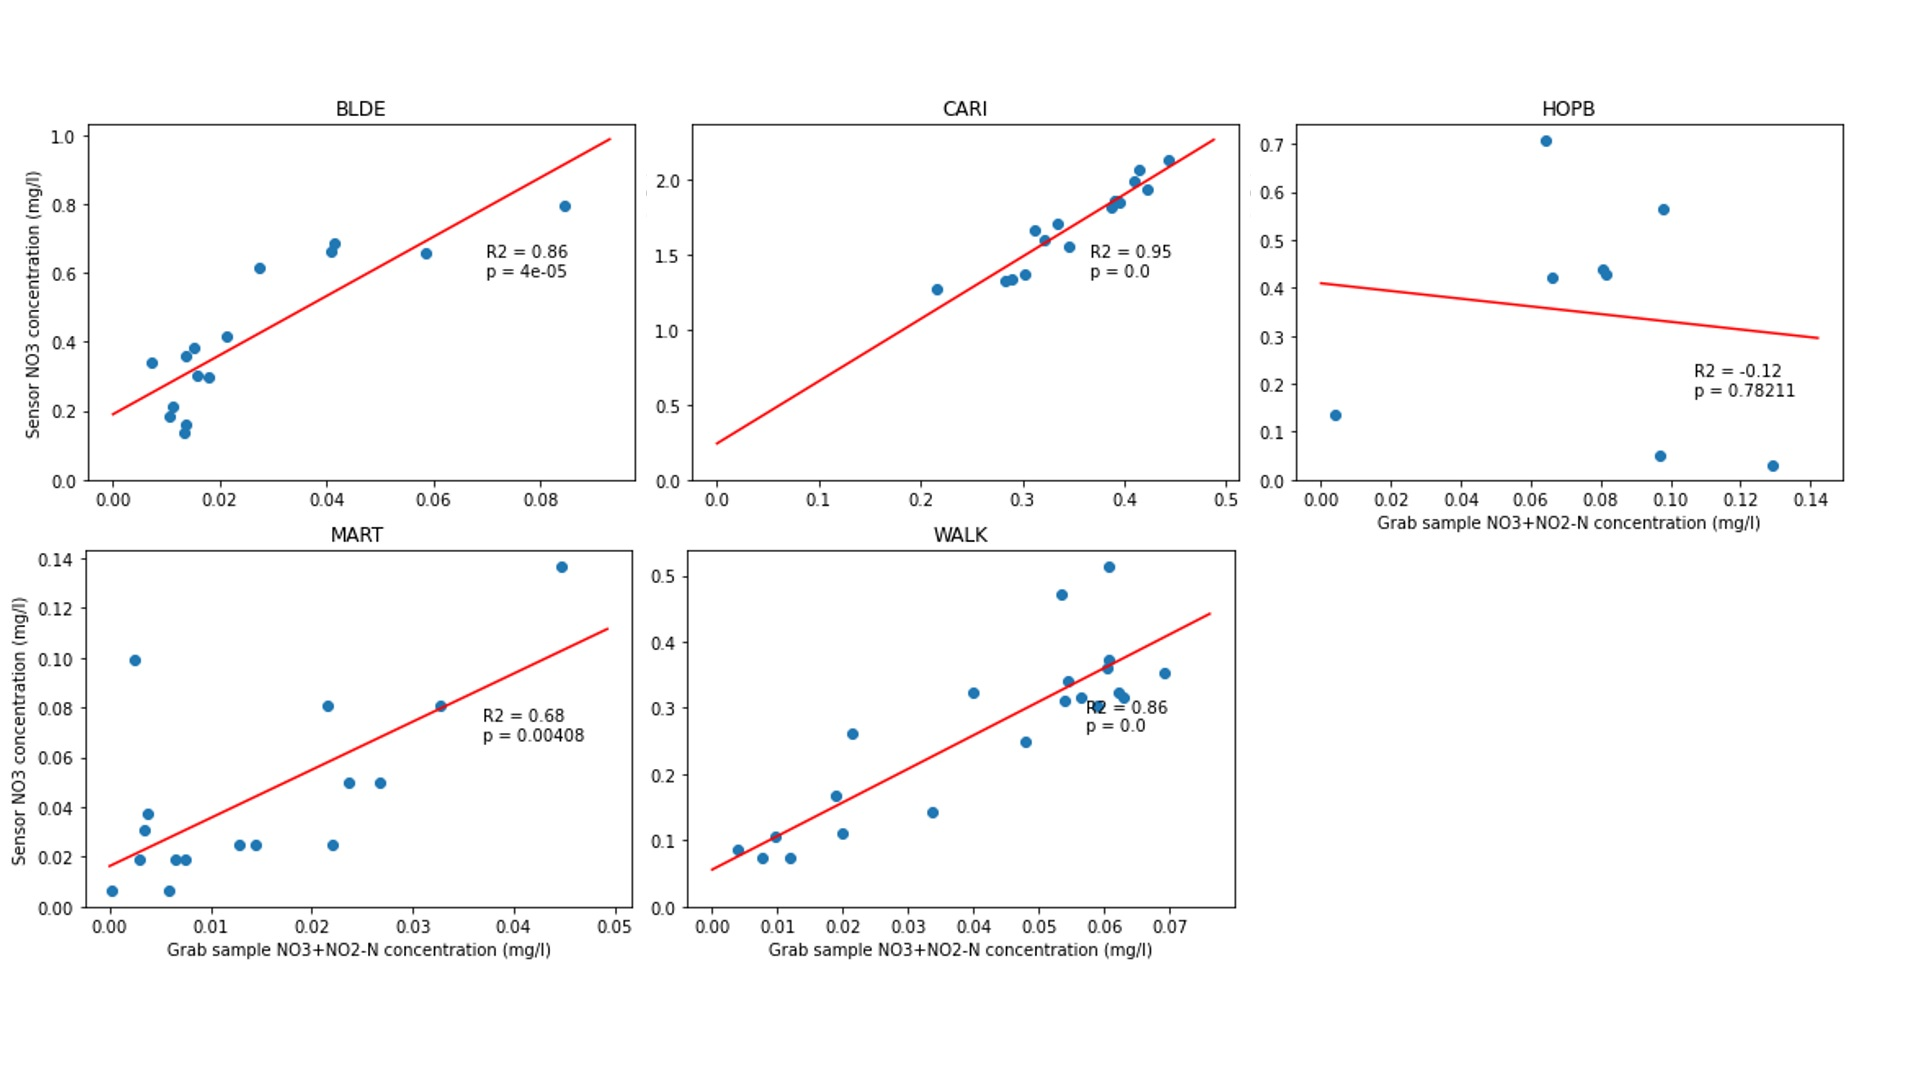

## 3.2 Discharge and nitrate
Continuous discharge measurements for 2019-2021 and nitrate concentrations are given in figure 4. These figures highlight the general variability of the measurements at each site, as well as seasonal trends in discharge and nitrate export at each site. These figures also identify periods of missing data which may need to be interpolated through models or complex statistical analyses, like a regression tree or hierarchical models.

Figure 4: Time series plots of discharge (blue) and nitrate (black) concentration at all five sites. Data gaps for periods smaller than one hour were gap filled using an interpolation of neighboring values. 
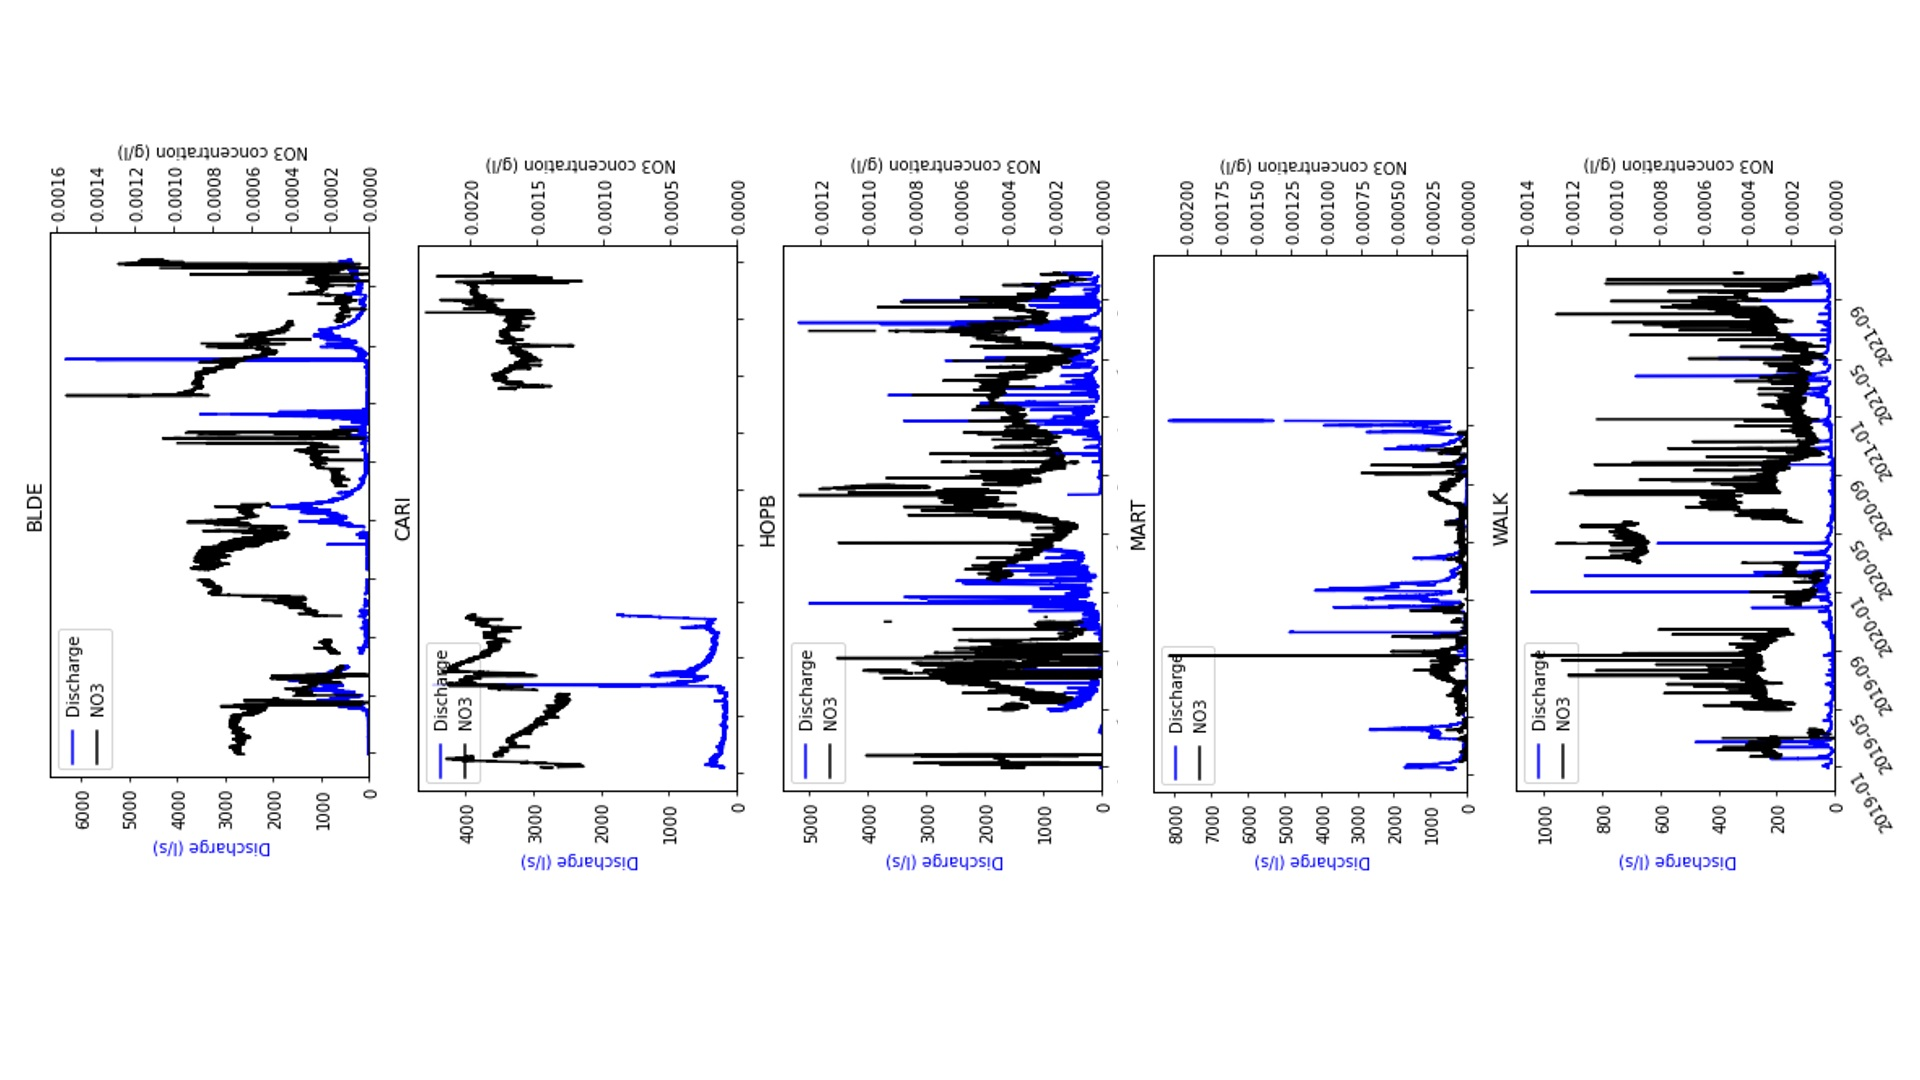


Figure 5 shows scatter plots of nitrate concentration in relation to discharge at all sites. An interpolation was calculated for each site; however, no relationship was found to be significant (p ˃ 0.05). Instead of considering these relationships at a multi-year scale, data were subdivided by month to calculate a power-law relationship between the two variables. The distribution of the nitrate concentrations and c-Q slopes are presented in figure 6. Two outlier values were removed from the c-Q slope boxplots to better visualize the differences between sites. For all five sites, the c-Q median c-Q slope was negative, indicating that higher discharge generally led to nitrate dilution (Musolff et al. 2015, Zimmer et al. 2019, Wymore et al. 2021). Mean monthly nitrate concentrations revealed large disparities between sites, Caribou Creek had the highest nitrate concentrations (mean: 1.73 mg/l), whereas Martha Creek had the lowest (mean: 0.07 mg/l). 

Figure 5: Range of (a) monthly c-Q slopes at all 5 sites and (b) mean monthly nitrate concentration at all five sites. Two outliers were removed from the c-Q slope figure for legibility, they are included in figure 6. 

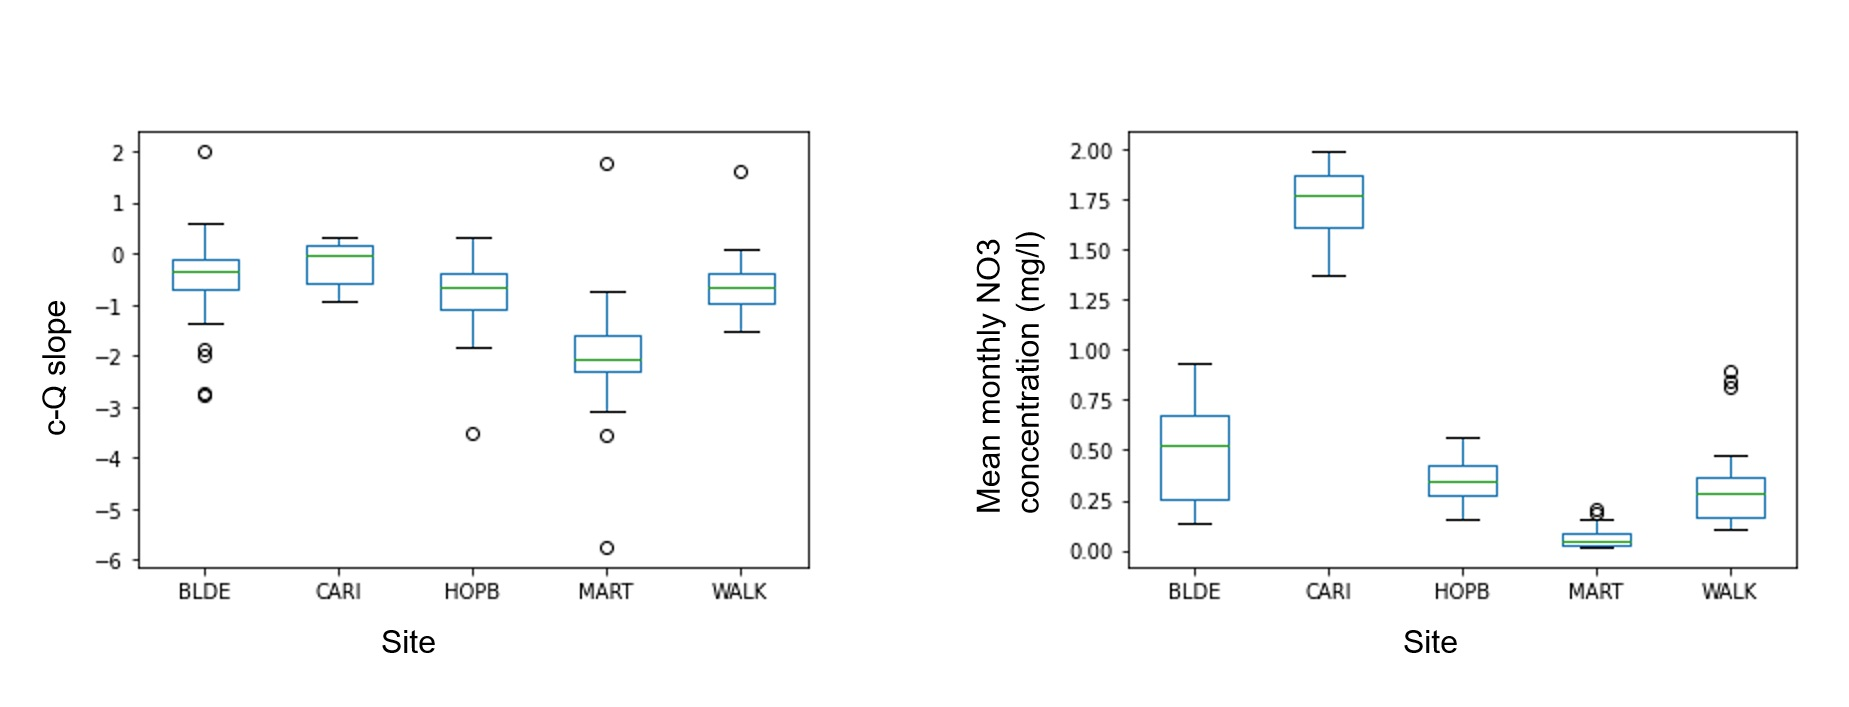

Figure 6 shows the changes in c-Q slope over time. Martha Creek had the largest variations in, with a minimum value of -13.37 and a maximum of 1.78. No general trends between sites emerge from this figure, highlighting the differences between these sites. The absence of pattern when comparing calendar dates may also reflect the difference in the timing of each season between sites; seasonal trends may emerge when this is considered.  

Figure 6: Time series of monthly c-Q slope at each site. Negative values indicate nitrate dilution with increasing discharge and positive values indicate nitrate concentration. 

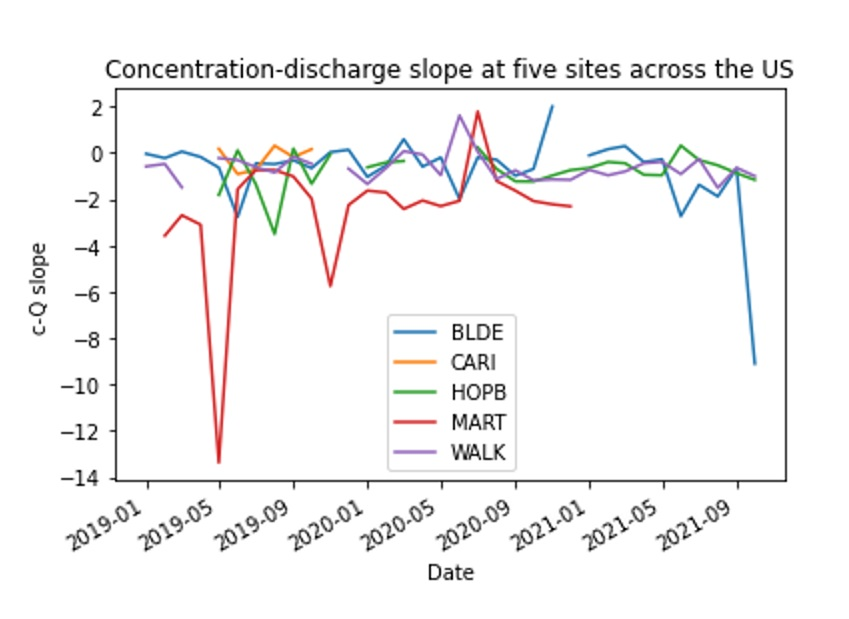

When comparing sites, the sites with the highest nitrate concentrations also have the highest c-Q slope values and vice-versa. This means that sites with the lowest nitrate concentrations experience the strongest dilution effect by higher discharge, whereas sites with higher nitrate concentrations do not experience as strong of a diluting effect and are more likely to concentrate nitrate during storm events (Zimmer et al. 2019, Wymore et al. 2021). Based on these results, we could hypothesize that sites that have a stronger dilution of nitrate at high discharge are source limited: nitrate quantities remain relatively stable at these sites and the water volume is the main factor that affects their concentration. On the other hand, sites that do not experience a strong dilution effect at high discharge may be transport limited, a more consistent concentration of nitrate enters the stream regardless of discharge, implying that higher water volumes allow access to new nitrate sources. These results also give insight to the state of nitrogen retention at each site, sites that have high stream nitrate concentrations and low nitrate dilution likely have higher soil nitrate concentrations. This either indicates high nitrate production from nitrifying bacteria and decomposition or low nitrate retention by plants in the system (Galloway 2004, Sudduth et al. 2013). These hypotheses are also supported by work comparing nitrate export to soil C:N ratios and plant C:N ratios: the plant and soil C:N values influence nitrate export in streams (Lovett et al. 2002).

# 4. Conclusion

Nitrate export to streams is influenced by multiple factors including ecosystem nitrate content, precipitation, temperature, soil properties, and vegetation (Poor et al. 2007, Zhi & Li 2020). During storm events, nitrate export generally increases as more nitrate is mobilized and leached to streams, however the magnitude of this response is variable between ecosystems and depends on environmental variables such as the ones mentioned above (Jones et al. 2018, Zimmer et al. 2019, Wymore et al. 2021). The results presented in this study highlight how stream nitrate export from different ecoregions respond to increased discharge. In general, increased discharge has a diluting effect on nitrate, however the magnitude of that effect changes between seasons and between sites. This could give us insight to whether a stream is source or transport limited for nitrogen. Further analyses need to be conducted to confirm some of the hypotheses posited here and would include doing comparative statistical analyses between sites, including data from more sites, and including data on plant or soil C:N ratios, mean monthly temperature and precipitation.

# References
Donner, S. D., Kucharik, C. J., and Foley, J. A. (2004), Impact of changing land use practices on nitrate export by the Mississippi River, Global Biogeochem. Cycles, 18, GB1028, doi:10.1029/2003GB002093

Duncan, J. M., Welty, C., Kemper, J. T., Groffman, P. M., and Band, L. E. (2017), Dynamics of nitrate concentration-discharge patterns in an urban watershed, Water Resour. Res., 53, 7349– 7365, doi:10.1002/2017WR020500.

Galloway JN, Dentener FJ, Capone DG, Boyer EW, Howarth RW, Seitzinger SP, Asner GP, Cleveland CC, Green PA, Holland EA, Karl DM, Michaels AF, Porter JH, Townsend AR, Vöosmarty CJ (2004) Nitrogen Cycles: Past, Present, and Future. Biogeochemistry 70: 153–226. https://doi.org/10.1007/s10533-004-0370-0

He, S., Lu, J. Contribution of baseflow nitrate export to non-point source pollution. Sci. China Earth Sci. 59, 1912–1929 (2016). https://doi.org/10.1007/s11430-016-5329-1

Jones, C. S., Schilling, K. E., Simpson, I. M., & Wolter, C. F. (2018). Iowa stream nitrate, discharge and precipitation: 30-year perspective. Environmental management, 62(4), 709-720.

LeBauer DS, Treseder KK (2008) Nitrogen limitation of net primary productivity in terrestrial ecosystems is globally distributed. Ecology 89: 371–379. https://doi.org/https://doi.org/10.1890/06-2057.1 

Likens GE (2013) Biogeochemistry of a forested ecosystem. Springer Science & Business Media. 

Lovett, G. M., Weathers, K. C., & Arthur, M. A. (2002). Control of nitrogen loss from forested watersheds by soil carbon: nitrogen ratio andtree species composition. Ecosystems, 5(7), 0712-0718.

Musolff, A., Schmidt, C., Selle, B., & Fleckenstein, J. H. (2015). Catchment controls on solute export. Advances in Water Resources, 86, 133-146.

NEON (National Ecological Observatory Network). Continuous discharge (DP4.00130.001). https://data.neonscience.org (accessed December 1, 2021)

NEON (National Ecological Observatory Network). Chemical properties of surface water (DP1.20093.001). https://data.neonscience.org (accessed December 1, 2021)

NEON (National Ecological Observatory Network). Nitrate in surface water (DP1.20033.001). https://data.neonscience.org (accessed December 1, 2021)

Paul, E. A., & Clarke, F. E. (1989). Soil microbiology and biochemistry (2nd ed.). San Diego: Academic.

Pellerin, B. A., Saraceno, J. F., Shanley, J. B., Sebestyen, S. D., Aiken, G. R., Wollheim, W. M., & Bergamaschi, B. A. (2012). Taking the pulse of snowmelt: in situ sensors reveal seasonal, event and diurnal patterns of nitrate and dissolved organic matter variability in an upland forest stream. Biogeochemistry, 108(1), 183-198.

Poor, C. J., & McDonnell, J. J. (2007). The effects of land use on stream nitrate dynamics. Journal of Hydrology, 332(1-2), 54-68.

Rusjan, S., Brilly, M., & Mikoš, M. (2008). Flushing of nitrate from a forested watershed: an insight into hydrological nitrate mobilization mechanisms through seasonal high-frequency stream nitrate dynamics. Journal of Hydrology, 354(1-4), 187-202.

Thomas RQ, Canham CD, Weathers KC, Goodale CL (2010) Increased tree carbon storage in response to nitrogen deposition in the US. Nature Geoscience 3: 13–17. 

Wymore, A. S., Fazekas, H. M., & McDowell, W. H. (2021). Quantifying the frequency of synchronous carbon and nitrogen export to the river network. Biogeochemistry, 152(1), 1-12.

Zhi, W., & Li, L. (2020). The shallow and deep hypothesis: subsurface vertical chemical contrasts shape nitrate export patterns from different land uses. Environmental Science & Technology, 54(19), 11915-11928. 

Zimmer, M. A., Pellerin, B., Burns, D., & Petrochenkov, G. (2019). Temporal variability in nitrate-discharge relationships in large rivers as revealed by high-frequency data. Water Resources Research, 55, 973– 989. https://doi.org/10.1029/2018WR023478 


# Addendum
## Discharge and nitrate hysteresis

An earlier version of this project involved observing the hysteresis curve for three storms at each site. This approach was not retained for final analysis for several reasons, including the subjective nature of storm selection and questions around data noise. Hysteresis plots can be seen for three selected storms using the code below.

The hysteresis curve is easy to read for certain storms/sites, however the nitrate data is noisy at multiple sites, making it hard to accurately analyse the differences between sites without smoothing out the data. As such, this analysis was not conducted in further depth, however this method may still be of interest for other analyses.


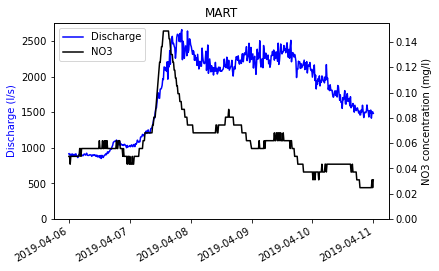

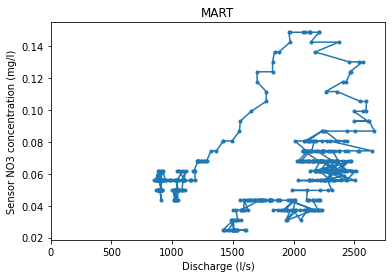

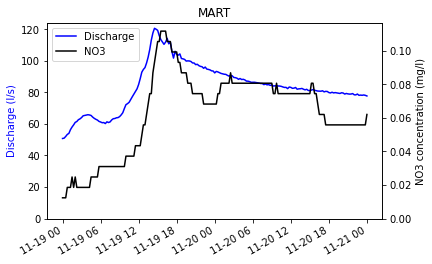

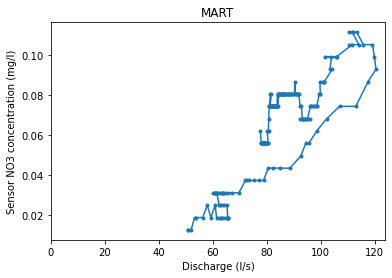

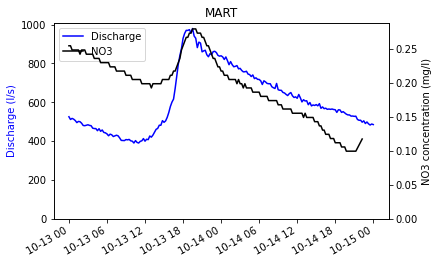

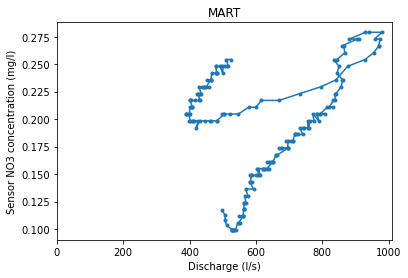

In [35]:
# Create plots for each of the storms
for i, one in enumerate(storms['start']):
    finalD = storms.iloc[i, 1]
    subdat = dfdat[one:finalD]
    timeseriesplot(subdat)
    stormcQ(subdat)
